In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)

y_truth  = f(x_test)
n_test = len(x_test)
n_test

50

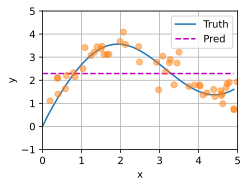

In [10]:
def plot_kernal_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], "x", "y", legend=["Truth", "Pred"],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernal_reg(y_hat)

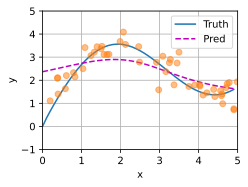

In [12]:
x_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(x_repeat - x_train) ** 2 /2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernal_reg(y_hat)

In [26]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行softmax 操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else: 
            valid_lens = valid_lens.reshape(-1)
    
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=1)


In [27]:
A1 = torch.rand(2,2,4)
A1

tensor([[[0.1106, 0.6438, 0.8789, 0.8813],
         [0.6294, 0.5249, 0.4843, 0.9078]],

        [[0.1785, 0.4696, 0.0219, 0.0438],
         [0.8368, 0.2174, 0.0850, 0.5156]]])

In [29]:
masked_softmax(torch.rand(2,2,4), torch.tensor([2, 3]))

tensor([[[0.3465, 0.6387, 0.5000, 0.5000],
         [0.6535, 0.3613, 0.5000, 0.5000]],

        [[0.5081, 0.6064, 0.6773, 0.5000],
         [0.4919, 0.3936, 0.3227, 0.5000]]])

In [35]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)

        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [37]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()

attention(queries, keys, values, valid_lens)

tensor([[[180., 190., 200., 210.]],

        [[180., 190., 200., 210.]]], grad_fn=<BmmBackward0>)

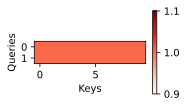

In [39]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')